In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.parser import parse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from hurst import compute_Hc
from datetime import date
import os
import datetime

In [2]:
!pip install statsmodels

In [3]:
# Import Data
df = pd.read_csv('NVD-Vulnerability-Volumes.csv',index_col=['Publication'],parse_dates=['Publication'],infer_datetime_format=True)
df.head()

,ID,ASSIGNER,DESCRIPTION,Count,v2 CVSS,v2 Vector,v2 Exploitability Score,v3 CVSS,v3 Vector,v3 Expoitability Score,CWE
Publication,,,,,,,,,,,
1999-12-30 05:00:00,CVE-1999-0001,"""cve@mitre.org""","""ip_input.c in BSD-derived TCP/IP implementati...",1.0,5.0,"""AV:N/AC:L/Au:N/C:N/I:N/A:P""",NaN,NaN,NaN,NaN,"""CWE-20"""
1998-10-12 04:00:00,CVE-1999-0002,"""cve@mitre.org""","""Buffer overflow in NFS mountd gives root acce...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""CWE-119"""
1998-04-01 05:00:00,CVE-1999-0003,"""cve@mitre.org""","""Execute commands as root via buffer overflow ...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other"""
1997-12-16 05:00:00,CVE-1999-0004,"""cve@mitre.org""","""MIME buffer overflow in email clients, e.g. S...",1.0,5.0,"""AV:N/AC:L/Au:N/C:N/I:N/A:P""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other"""
1998-07-20 04:00:00,CVE-1999-0005,"""cve@mitre.org""","""Arbitrary command execution via IMAP buffer o...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other"""


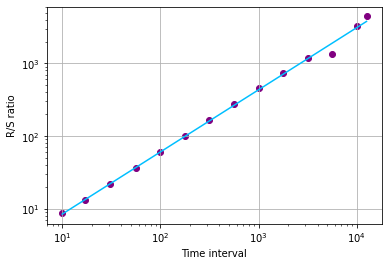

H=0.8556, c=1.1727


In [4]:
#Examine the data with the Hurst component to convinces ourselves this is possible (and lo0k at different timeframes of possibility)
H, c, data = compute_Hc(df['Count'].resample('D').sum(), kind='change',simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

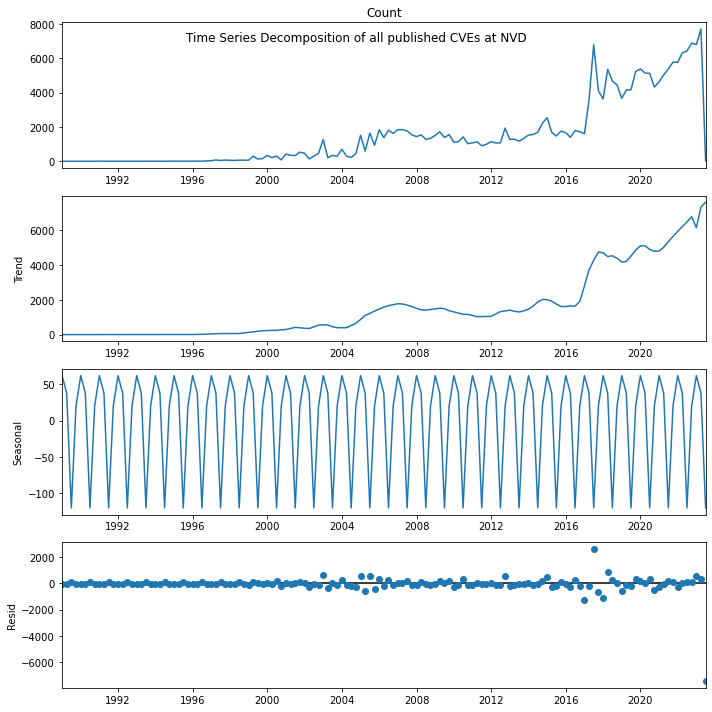

In [5]:
# Decompose 
result = seasonal_decompose(df['Count'].resample('Q').sum(), model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result.plot().suptitle('Time Series Decomposition of all published CVEs at NVD', y=0.95)
plt.show()

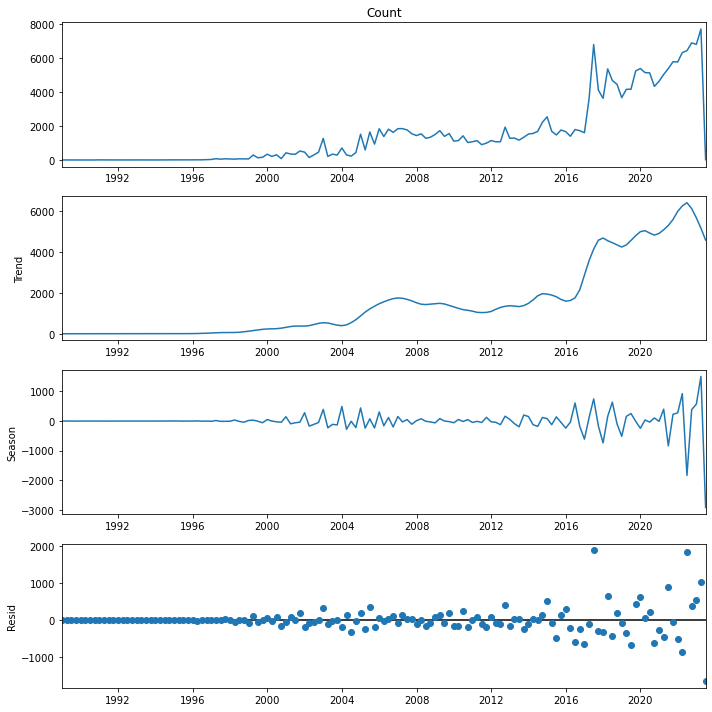

In [6]:
#Given our naive decomposition shows promise, let's go with STL since it can handle all kinds of seasonality
#We also must use additive since we have periods of zero in our data, so STL will fit the task
stl_result = STL(df['Count'].resample('Q').sum()).fit()
chart = stl_result.plot()
plt.show()

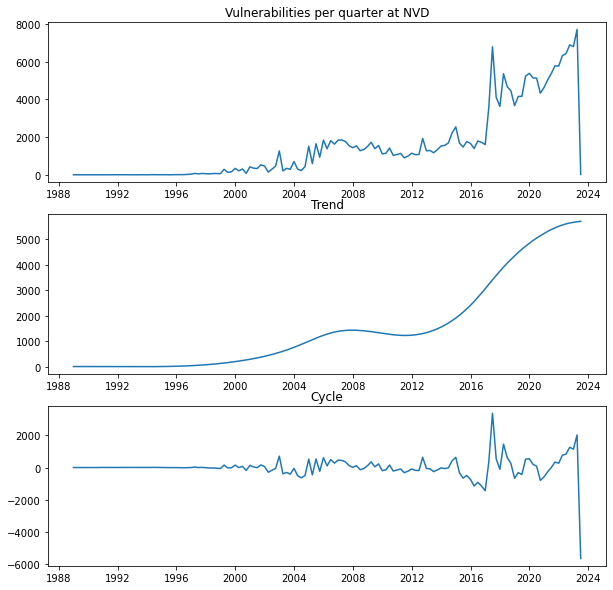

In [7]:
cycle, trend = sm.tsa.filters.hpfilter(df['Count'].resample('Q').sum(), 1600) #quarterly is 1600, monthly 129600, #weekly 33177600.
fig, ax = plt.subplots(3,1)
ax[0].plot(df['Count'].resample('Q').sum())
ax[0].set_title('Vulnerabilities per quarter at NVD')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


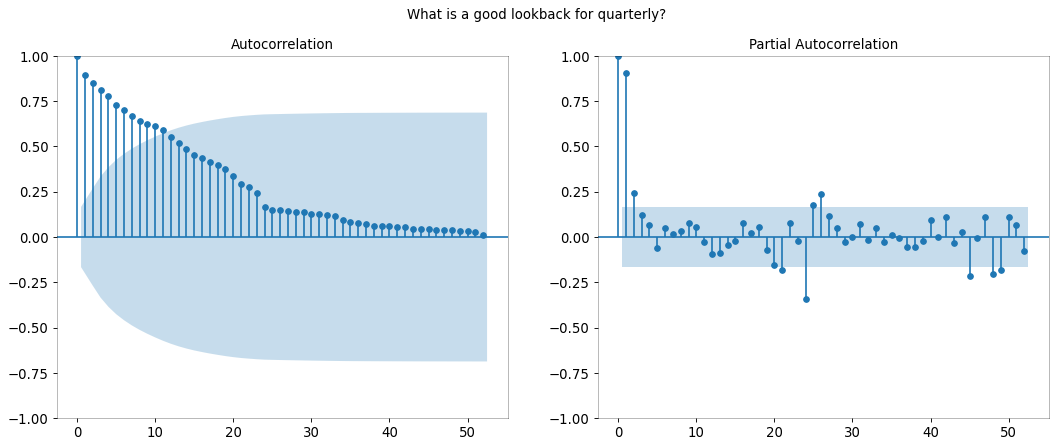

In [8]:
# Import Data
#df = all_vulns

# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(df['Count'].resample('Q').sum().tolist(), ax=ax1, lags=52)
plot_pacf(df['Count'].resample('Q').sum().tolist(), ax=ax2, lags=52)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fig.suptitle("What is a good lookback for quarterly?")
plt.show()

Test for trend MSE: 0.5702201328669425


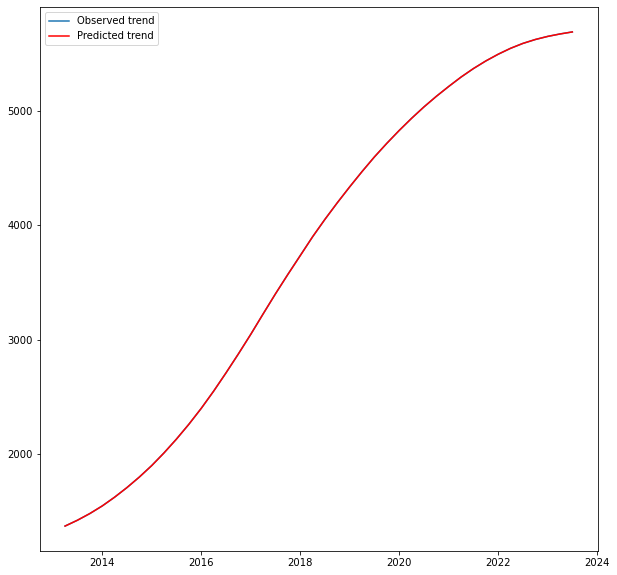

Test for cycle MSE: 1486.9925293050637


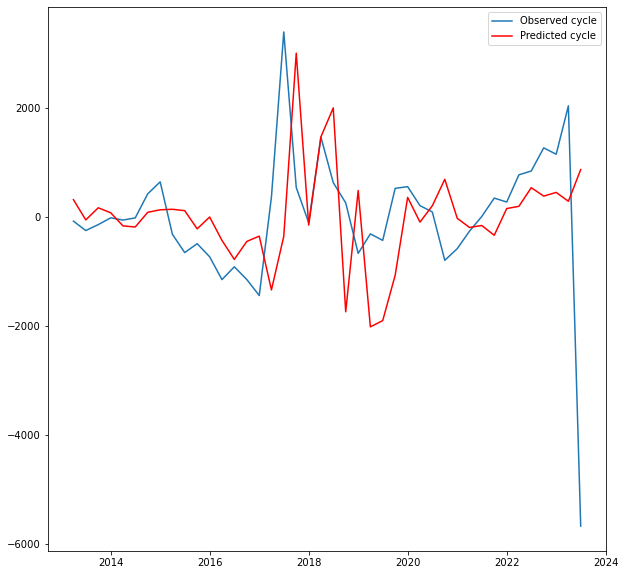

In [9]:
#Given we think it is predictable...let's try simple autoregression
component_dict = {'cycle': cycle, 'trend': trend}
prediction_results = []
for component in ['trend', 'cycle']:
    #Remove the one behind predictions
    historic = component_dict[component].iloc[:int(len(df['Count'].resample('Q').sum()) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(df['Count'].resample('Q').sum()) * 0.7):]
    predictions = []
    for i in range(len(test)):
        #10 here comes from our autocorrelation graph
        model = AutoReg(historic, lags=10, seasonal=True,period=4).fit()
        pred = model.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

In [10]:
#Make two forecasts
model.forecast(steps=2)
#Not great, let's try SARIMAX

array([864.21801229, 191.11910404])

In [23]:
#Make the cutoff the last date of last quarter
last_quarter = df['Count'].resample('Q').max().fillna(method='bfill').index[-1].quarter-1
this_quarter = df['Count'].resample('Q').max().fillna(method='bfill').index[-1].quarter
if last_quarter == 0:
    year = datetime.datetime.now().year - 1
    cutoff = datetime.datetime(year, 12, 31, 0, 0)
elif last_quarter == 1:
    cutoff = datetime.datetime(datetime.datetime.now().year, 3*last_quarter, 31, 0, 0)
else:
    cutoff = datetime.datetime(datetime.datetime.now().year, 3*last_quarter, 30, 0, 0)

#We'll want to check our progress through the quarter so we do need that as a data set later
check=df[df.index.tz_localize(None)>cutoff]
#The data we'll predict from shouldn't contain any data for this quarter
df=df[df.index.tz_localize(None)<=cutoff]
# Construct the model
mod = sm.tsa.SARIMAX(df['Count'].resample('Q').sum(), order=(1, 2, 4), exog=None, trend='ct')
res = mod.fit()

print(res.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62225D+00    |proj g|=  2.89560D-01

At iterate    5    f=  7.57201D+00    |proj g|=  2.54405D-02

At iterate   10    f=  7.56714D+00    |proj g|=  9.35935D-03

At iterate   15    f=  7.56659D+00    |proj g|=  1.13994D-02

At iterate   20    f=  7.56640D+00    |proj g|=  2.59014D-03

At iterate   25    f=  7.56440D+00    |proj g|=  3.69624D-02

At iterate   30    f=  7.55528D+00    |proj g|=  1.33818D-01

At iterate   35    f=  7.55438D+00    |proj g|=  4.92354D-03

At iterate   40    f=  7.55381D+00    |proj g|=  3.49345D-03

At iterate   45    f=  7.55378D+00    |proj g|=  2.15921D-03

At iterate   50    f=  7.55219D+00    |proj g|=  5.31471D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


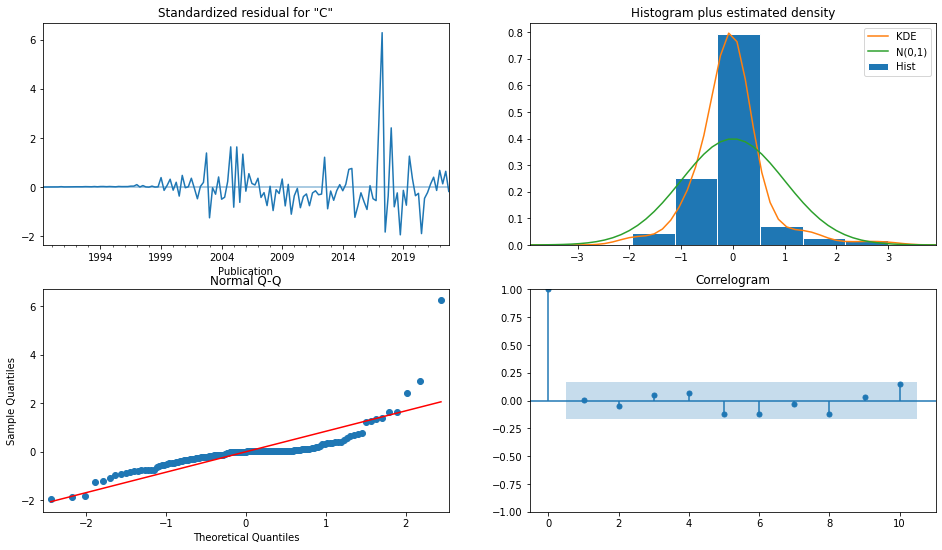

In [24]:
# Plot diagnostics
res.plot_diagnostics(figsize=(16, 9))
plt.show()

In [25]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(steps=2)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.05))

Count              mean     mean_se  mean_ci_lower  mean_ci_upper
2023-03-31  6965.137210  582.928075    5822.619178    8107.655242
2023-06-30  7140.367787  686.492335    5794.867535    8485.868039


In [26]:
today = date.today()
current_datetime = today.strftime("%b-%d-%Y")
#Note this format will overwrite all forecasts produced on the same day
file_name = current_datetime+"-Quarterly-vuln4cast.csv"
path = 'QuarterlyForecasts/'
try:
   os.makedirs(path)
except FileExistsError:
   # directory already exists
   pass
fcast_res1.summary_frame(alpha=0.05).to_csv(path+file_name)

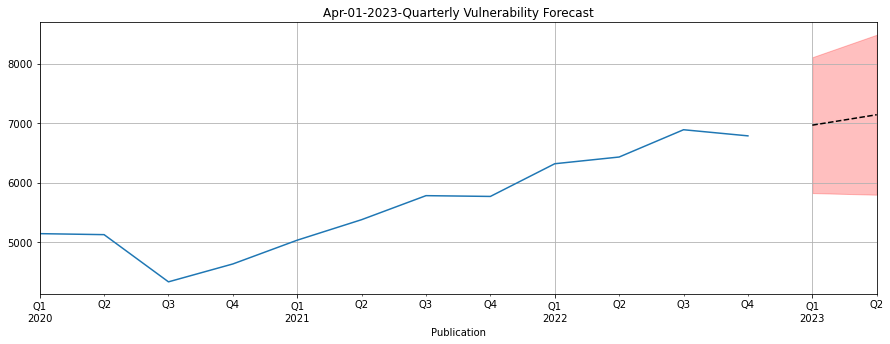

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.title(current_datetime+"-Quarterly Vulnerability Forecast")

# Plot the data (here we are subsetting it to get a closer look at the forecasts than the full history)
df['Count'].resample('Q').sum().loc['2020Q1':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(steps=2).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='r', alpha=0.25);
ax.grid()

image_name = current_datetime+"-Quarterly-vuln4cast.png"
plt.savefig(path+image_name)

In [28]:
#Now check how we're doing so far...
print(fcast_res1.summary_frame(alpha=0.05))
print('The current count of published NVD vulns is: '+str(check['Count'].sum()))

Count              mean     mean_se  mean_ci_lower  mean_ci_upper
2023-03-31  6965.137210  582.928075    5822.619178    8107.655242
2023-06-30  7140.367787  686.492335    5794.867535    8485.868039
The current count of published NVD vulns is: 7661.0
